<a href="https://colab.research.google.com/github/shanmugt-hub/walsh/blob/main/nlp/IT_720_Assignment_2_ShanmuganathanT_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IT 720: NLP, Assignment 2

When you submit the assignment, make sure that you:

- add your name to the file name
- shut down the kernel one last time, restart it, and run your code from start to finish.
- leave the output in each cell to allow the grader to see it
- if there is a bug that you cannot resolve, leave the error message in the output cell so the grader can see it

### Rubric for the numbered sections below where you must write your own code, 175 points total
1.  10 points: Train, Valid, Test Split
2.  20 points: BiLSTM
3.  20 points: BiLSTM with Classifier Head
4.  20 points: Fit Encoder
5.  20 points: Visualize Training Loss and Accuracy
6.  20 points: Create Sentence Embeddings
7.  20 points: Define and Train FFClassifier
8.  15 points: Combine Data and Retrain
9.  10 points: Confusion Matrix
10. 20 points: Two UMAP Scatterplots


### Assignment 2 – Neural Sentence Embeddings with BiLSTM + Feedforward Classifier

#### The first 3 code cells are provided to help you get started, as well a few other cells below.

In this assignment, your code will:

- Build a neural **sentence encoder** using a bi‑directional LSTM
- Learn the word (token) embeddings
- Use the encoder to generate **fixed‑dimensional embeddings** for movie reviews.
- Train a **feed‑forward neural network (FFNN)** classifier on top of these embeddings.
- Evaluate performance and conduct **error analysis** on misclassified examples.

This solution notebook contains:

1. Data loading and (minimal) preprocessing  
2. BiLSTM sentence encoder construction and training  
3. Embedding extraction for all reviews  
4. Feed‑forward classifier training
5. Evaluation and confusion matrix  
6. Error analysis with concrete examples


In [1]:
# This cell contains all packages and functions you need to do the assignment.
# You may substitute PyTorch code instead of Keras/Tensorflow, but you would
# have to replace many imports here with similar imports for PyTorch.

import nltk
import os
import random
# !pip install umap-learn --quiet  # One time installation
import umap # We use this to visualize the movie review vector space

import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import tensorflow        as tf


from nltk                    import word_tokenize
from nltk.corpus             import movie_reviews
from sklearn.metrics         import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks              import EarlyStopping
from tensorflow.keras.layers                 import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models                 import Model, Sequential
from tensorflow.keras.optimizers             import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text     import Tokenizer

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


## Reproducibility and setup

We set random seeds for `numpy`, Python's `random`, and TensorFlow to reduce variance in results.  
Note: in real training, results will still vary slightly across runs and hardware, but this helps.


In [2]:
SEED = 34

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# The next line is for GPU determinism (may not be perfect across all environments)
# If this generates an error, just delete it. It's optional.
os.environ["PYTHONHASHSEED"] = str(SEED)


## Loading the movie reviews corpus

We reuse the same **NLTK `movie_reviews`** dataset as in Assignment 1.

- Each document is a full review.
- Each review is labeled with a **sentiment**: `pos` or `neg`.
- We will:
  - Extract raw tokenized reviews.
  - Convert them into text sequences (space‑joined tokens).
  - Assign integer labels: `0` for negative, `1` for positive.


In [3]:
# Load the movie reviews
nltk.download('movie_reviews')

# movie_reviews.fileids() gives list like ['neg/cv000_29416.txt', 'pos/cv000_29590.txt', ...]
fileids = movie_reviews.fileids()
print("Number of documents:", len(fileids))
print("Example fileid:", fileids[0])

# Extract documents and labels
documents = []
labels    = []    # We will add 0 for negative review and 1 for positive

for fid in fileids:
    # tokens: list of strings
    tokens = movie_reviews.words(fid)
    # join back into a whitespace-separated string
    text = " ".join(tokens)
    documents.append(text)

    # label: 'pos' or 'neg'
    label = movie_reviews.categories(fid)[0]
    labels.append(1 if label == "pos" else 0)

print("\nExample document:")
print(documents[0][:500], "...")
print("\nLabel (0=neg, 1=pos):", labels[0])


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


Number of documents: 2000
Example fileid: neg/cv000_29416.txt

Example document:
plot : two teen couples go to a church party , drink and then drive . they get into an accident . one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . what ' s the deal ? watch the movie and " sorta " find out . . . critique : a mind - fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . which is what makes this review an even harder one to write , since i generally applaud films which attempt t ...

Label (0=neg, 1=pos): 0


# Your own code will begin here.

## 1. Train/validation/test split

Add your own code to split the dataset into:

- **Train**: for fitting the BiLSTM encoder and the FFNN.
- **Validation**: for early stopping during BiLSTM training.
- **Test**: held‑out data for final evaluation.

Using scikit-learn's train_test_split, create an 80-20 split for training and test data, but then do another 80-20 split on that training data to get a training set with 64% of the original 2000 reviews with 16% of the 2000 held out for validation.

Please create the following variable names in your code for the training, validation and test sets:
- X_train, y_train
- X_val,   y_val
- X_test,  y_test

After you have set the variables print out the shapes of X_train, X_val and X_test

In [14]:
X = np.array(documents)
y = np.array(labels)

# First split: 80% for train+val, 20% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Second split: 80% of train+val for train, 20% of train+val for val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=SEED)

# Print out shapes
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1280,)
Shape of X_val: (320,)
Shape of X_test: (400,)
Shape of y_train: (1280,)
Shape of y_val: (320,)
Shape of y_test: (400,)


## Tokenization and integer encoding

We now:

1. Fit a Keras `Tokenizer` on the training text.
2. Convert texts to integer sequences.
3. Pad sequences to a fixed maximum length.


In [15]:
# This cell is provided to you and shows how to create and use a simple
# whole-word based tokenizer using Keras' Tokenizer utility. The Keras
# documentation is not very good regarding tokenizers. However, the following
# HuggingFace page does provide good detail on several approaches to
# tokenization, and is a good supplement to the somewhat limited discussion
# that you can find in Jurafsky and Martin's chapter on 'Words and Tokens'
# https://huggingface.co/docs/transformers/fast_tokenizers

MAX_VOCAB_SIZE = 10000   # This will limit our total vocab size to most frequent 10000 in the data
MAX_SEQ_LEN    = 256     # Truncate/pad to this length so every review is same length
EMBEDDING_DIM  = 128     # Dimensionality of learned token embeddings

# The next line will add '<OOV>' to the list of vocabulary words and assign it the integer 1.
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")

# When fit_on_texts is called, it will find the top 9,999 words by frequency and assign a unique integer to each word.
# Integer 1 has already been assigned to the special vocab token <OOV>, so any word found in the texts
# that is not among those top 9,999 will just get assigned the 1.
tokenizer.fit_on_texts(X_train)

def texts_to_padded_sequences(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return(pad_sequences(seqs, maxlen=MAX_SEQ_LEN, padding='post', truncating='post'))

X_train_seq = texts_to_padded_sequences(X_train)
X_val_seq   = texts_to_padded_sequences(X_val)
X_test_seq  = texts_to_padded_sequences(X_test)

print("Train sequences shape:\t\t",    X_train_seq.shape)
print("Validation sequences shape:\t", X_val_seq.shape)
print("Test sequences shape:\t\t",     X_test_seq.shape)

# Each review has now been converted to a sequence of integers. Remember, 1 represents any low frequency word
# which could be a misspelling or simply a very rare word.
# Let's look at the tokenization of the first review in the training sequences:

print('\nThe tokenization of the first review in X_train_seq is:')
X_train_seq[0]

Train sequences shape:		 (1280, 256)
Validation sequences shape:	 (320, 256)
Test sequences shape:		 (400, 256)

The tokenization of the first review in X_train_seq is:


array([9142,  162,   99,    8,   30, 3754, 1730,    5,    2, 8322,   33,
          2, 2580,  299,    5,  452,  119, 2652, 1503,   28,   79,  339,
          9,    2,  156,   87, 1795,    9,    3,  410, 1603,   22,   16,
       3153,    5,   40,  386, 1503, 5146,   46,    9, 4876,  315,    3,
       4068, 7049,    5,    1,   98, 2431, 3491,    1,    2,  399,    5,
       3755, 5445,    1, 1503,   38,  504,  386,    6, 2953,   80,    1,
         12,   20,    7,   10, 1628,    5, 3043,   22,    6, 2431,    1,
          5, 2031, 1966, 1996, 3492,   13,    2, 3154, 1158,   28,    1,
       1503,    9, 1763,  411,    1,  524, 1764,  227,   16, 2954, 1503,
        234,  781, 2581,    5,   16,   99,   22,    3,   29,  217,    4,
        112,  118,   23,  168, 7606,  155,    4, 2719, 3493,   11,    7,
         10,  822,    6, 5756,    1,    4,    1,   35, 1503,   13,   20,
          4, 3492,  430,    6, 1327,  226,   16, 8323, 1967,   22,  464,
       3492,    9,  871,    8,    9, 8324,  381,  5

## 2. Building the BiLSTM sentence encoder

Build a Keras model that takes a sequence of token IDs and returns a **fixed‑dimensional sentence embedding**
In doing so, the model will also learn embeddings for the tokens.

Architecture:

- Input: integer sequence of length `MAX_SEQ_LEN`.
- Embedding layer: maps tokens to `EMBEDDING_DIM`‑dimensional learned vectors.
- BiLSTM: processes the sequence in both directions.
- We set `return_sequences=False` to get a single vector per sequence.
- A final dense layer to reshape the reviews dimension and add nonlinearity. This has been supplied for you.

The final encoder outputs a sentence embedding vector of reduced dimensionality, i.e. fewer dimensions than output of the biLSTM.

The shrinking of the final sentence embedding is because:
a. Fewer dimensions may result in less overfitting due to the reduced capacity of representation. You will see
   that overfitting may be a huge issue for this assignment, mainly because of the tiny size of the dataset
   
b. A 'bottleneck' of the  dimensionality for the sentence embeddings allows
    you to make changes elsewhere and still arrive at the same final dimensionality
    vis-a-vis the representation capacity of a biLSTM.
    
c. The tanh activation reshapes the embedding space into a bounded, centered region. This often
   makes downstream classifiers behave more predictably


In [ ]:
inputs = Input(shape=(MAX_SEQ_LEN,))
x = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True)(inputs)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
sentence_embedding = Dense(48, activation='tanh', name="sentence_embedding")(x)

# We will complete the model with a classification head in the next step
# and then define the 'biLSTM' model variable.

In [16]:
# Build sequential LSTM model in Keras (or PyTorch, if you prefer).
# You can choose your own hyperparameter values, e.g. number of units for the layers,
# names of layers, etc. unless otherwise noted.

# Begin with an Input layer that takes reviews with shape=(MAX_SEQ_LEN,)
# Add an Embedding layer to learn word (token) embeddings
#     with input dimensions of MAX_VOCAB_SIZE and output dimensions of EMBEDDING_DIM defined above
# Add a bidirectional LSTM with return_sequences=False and that outputs 64 dimensions
#     in each direction producing 128 dimensions for final LSTM output
# Follow the biLSTM with a Dense layer that outputs only 48 dimensions. This is the 'bottleneck' mentioned above.
# This Dense layer should use a 'tanh' activation function.
# The output of this Dense layer will be the input to a small Classifier to perform the review classification
# Give this Dense layer a name by using name="sentence_embedding".  We will reference that name later.


inputs = Input(shape=(MAX_SEQ_LEN,))
x = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True)(inputs)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
sentence_embedding = Dense(48, activation='tanh', name="sentence_embedding")(x)

# We will complete the model with a classification head in the next step
# and then define the 'biLSTM' model variable.









## 3. Training the BiLSTM encoder for sentiment classification

Before we train our biLSTM, we need to give it a supervisory signal for training that is relevant to our task of classifying movie review sentiments. Without that signal, the learned token embeddings will not be able to contribute useful information to the desired task.  Therefore, we will attach a simple classification head to our encoder solely for this purpose. Do not confuse the classification head here with the Feed Forward Classifier that we will create later after we train the encoder.  

To train the encoder, we attach a classification head by simply following the sentence_embedding layer with:
- Dropout layer for regularization, choosing your own value for the dropout rate.
- Dense layer with 1 unit and sigmoid activation for binary sentiment.

Make sure you have saved your entire encoder with its classifer head into a variable called 'biLSTM'.
Compile biLSTM with "binary_crossentropy" for the loss function, the Adam optimizer and metrics=["accuracy"]

Call biLSTM.summary() to see a descrition of your complete encoder. You should see 6 layers in the output:
1. Input
2. Embedding
3. Bidirectional
4. Dense
5. Dropout
6. Dense


In [ ]:
x = Dropout(0.3)(sentence_embedding) # Example dropout rate of 0.3
outputs = Dense(1, activation='sigmoid')(x)

biLSTM = Model(inputs=inputs, outputs=outputs)

biLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

biLSTM.summary()

In [17]:
# Finish the rest of the encoder as just described.
# Compile it and call biLSTM.summary() to view the results.

x = Dropout(0.3)(sentence_embedding) # Example dropout rate of 0.3
outputs = Dense(1, activation='sigmoid')(x)

biLSTM = Model(inputs=inputs, outputs=outputs)

biLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

biLSTM.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 256, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 256)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     98,816 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentence_embedding  │ (None, 48)        │      6,192 │ bidirectional[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 48)        │          0 │ sentence_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         49 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,385,057 (5.28 MB)

 Trainable params: 1,385,057 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Training with early stopping

We train the model and use `EarlyStopping` on validation loss (`val_loss`) to try to prevent overfitting.
Use `restore_best_weights=True` in the case that early stopping is triggered in order to have the best weights returned.

Save the results of the training into the variable 'history', which we will use
to plot the loss and accuracy curves below.

Key hyperparameters are:

- Batch size
- Number of epochs
- Learning rate (set above for Adam, if you wish to change the default)
- Dropout rate (set above)
- The `patience` for early stopping (i.e. how many epochs with no improvement in validation loss for early stopping)
- Use `verbose=1` if you wish to see the output for each epoch during training.


In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = biLSTM.fit(X_train_seq, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val_seq, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 387ms/step - accuracy: 0.5084 - loss: 0.6941 - val_accuracy: 0.5219 - val_loss: 0.6914
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 386ms/step - accuracy: 0.7346 - loss: 0.6453 - val_accuracy: 0.5938 - val_loss: 0.6730
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 392ms/step - accuracy: 0.9437 - loss: 0.2611 - val_accuracy: 0.6187 - val_loss: 0.8432
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 385ms/step - accuracy: 0.9958 - loss: 0.0325 - val_accuracy: 0.5938 - val_loss: 1.2852
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 397ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 0.6094 - val_loss: 1.2392
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 387ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6031 - val_loss: 1.3676
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 400ms/step - accuracy: 1.0000 - loss: 3.8081e-04 - val_accuracy: 0.6062 - val_loss: 1.4153


## 5. Visualizing training and validation curves

Using matplotlib, write code for two plots:
1. Training and Validation loss
2. Training and validation accuracy

Each plot should show the epochs on the horizontal axis, the metric on the vertical axis, and a legend that shows a different color for the Training vs. Loss or Accuracy curves.

These plots will be useful to visually display any:
- Underfitting vs overfitting behavior.
- The point at which early stopping kicks in.

Make sure you have saved the results of your model's fit into 'history'

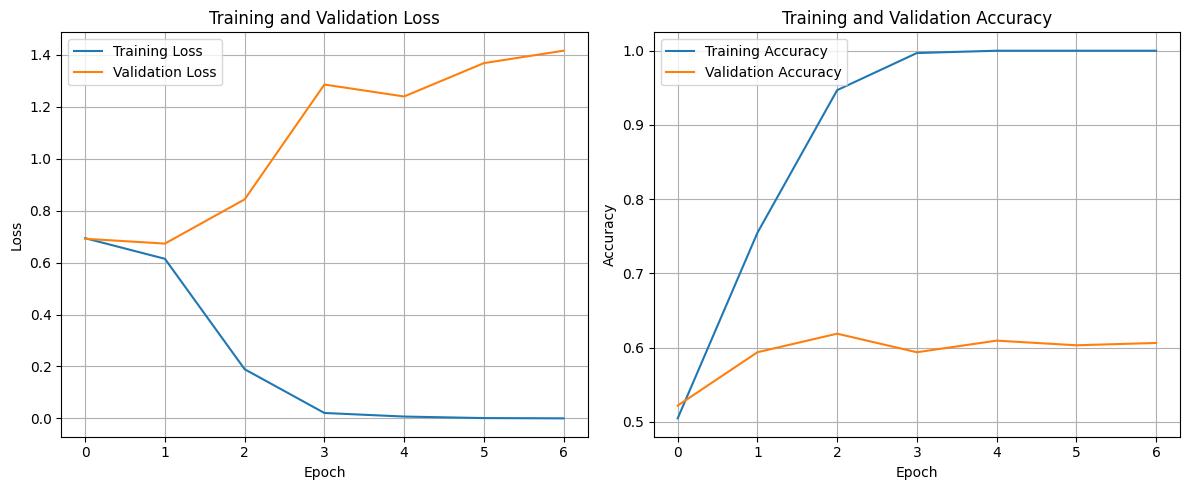

In [19]:
plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Baseline: BiLSTM classifier performance

Before we decouple the encoder and classifier, we can measure how well the full BiLSTM model performs on the test set. This gives a baseline:

- Test accuracy
- Classification report for Precision/recall/F1

Later, we compare this to the FFClassifier trained on learned embeddings.  You can copy/adapt this code later and use it for other models.


In [20]:
# Predict probabilities with threshold at 0.5
y_test_pred_proba = biLSTM.predict(X_test_seq)
y_test_pred       = (y_test_pred_proba >= 0.5).astype(int)

print("BiLSTM model test accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification report (BiLSTM model):")
print(classification_report(y_test, y_test_pred, target_names=["neg", "pos"]))


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step
BiLSTM model test accuracy: 0.565

Classification report (BiLSTM model):
              precision    recall  f1-score   support

         neg       0.55      0.73      0.63       201
         pos       0.59      0.40      0.48       199

    accuracy                           0.56       400
   macro avg       0.57      0.56      0.55       400
weighted avg       0.57      0.56      0.55       400



## 6. Create sentence embeddings from the trained encoder

Now use the **encoder part only** (up to and including the `sentence_embedding` layer) to generate fixed‑dimensional vectors for each review.

Steps:

1. Extract the encoder inputs from:  `biLSTM.input`
2. Extract the encoder outputs from: `biLSTM.get_layer("sentence_embedding").output`
3. Use the Keras `Model` class to construct a new model from those inputs and outputs, saving the model into a new variable, e.g. maybe you want to use 'encoder_only_model'.
4. Use the 'predict' method of that new model on each of `X_train_seq`, `X_val_seq`, and `X_test_seq` to convert each movie review to a sentence embedding created by the bidirectional LSTM that was previously trained.
5. Store those embeddings into new variables, e.g. X_train_emb for the training reviews.
6. Call `encoder_only_model.summary()` (if that's the name you used) to verify the architecture
7. Print the shapes of the three new variables where you saved the results of Step 5.


In [21]:
# Rebuild the encoder model that outputs the sentence embedding
# Extract the encoder part only
encoder_only_model = Model(inputs=biLSTM.input, outputs=biLSTM.get_layer("sentence_embedding").output)

# Generate sentence embeddings
X_train_emb = encoder_only_model.predict(X_train_seq)
X_val_emb   = encoder_only_model.predict(X_val_seq)
X_test_emb  = encoder_only_model.predict(X_test_seq)

# Verify the architecture of the encoder-only model
encoder_only_model.summary()

# Print shapes of the new embedding variables
print("\nShape of X_train_emb:", X_train_emb.shape)
print("Shape of X_val_emb:", X_val_emb.shape)
print("Shape of X_test_emb:", X_test_emb.shape)

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 256, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 256)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     98,816 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentence_embedding  │ (None, 48)        │      6,192 │ bidirectional[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,385,008 (5.28 MB)

 Trainable params: 1,385,008 (5.28 MB)

 Non-trainable params: 0 (0.00 B)


Shape of X_train_emb: (1280, 48)
Shape of X_val_emb: (320, 48)
Shape of X_test_emb: (400, 48)


## 7. Define, compile and train a a new feed‑forward neural network (FFClassifier) on embeddings that you just saved.

We now use the Keras to build a new **feed‑forward neural network** with 3 layers:

- Input layer: to accept the sentence embeddings that you just created and saved.
- Hidden layer: a Dense layer with a configurable number of units (your choice) and using "relu".
- Output layer: a Dense layer with 1 unit and the "sigmoid" activation function.

Compile this network as before, define EarlyStopping as before and fit the classifier, again saving it into 'history' or a different history variable of your choice.

Make sure you use the embeddings you saved for the movie reviews for both training and validation.

Predict the sentiment on the VALIDATION set, in a similar way (i.e. using 0.5 as the class threshold) that we predicted the test data the earlier model, but making sure you use the VALIDATION set embeddings that you just saved.

Print the validation data accuracy and classification report, again as you have already done above.

In [22]:
# Define the FFClassifier model
ff_classifier = Sequential([
    Input(shape=(X_train_emb.shape[1],)),  # Input layer for sentence embeddings
    Dense(64, activation='relu'),        # Hidden layer with 64 units (configurable)
    Dropout(0.3),                        # Adding dropout for regularization
    Dense(1, activation='sigmoid')       # Output layer for binary classification
])

# Compile the FFClassifier
ff_classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define EarlyStopping for the FFClassifier
early_stopping_ff = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the FFClassifier
history_ff = ff_classifier.fit(X_train_emb, y_train,
                             epochs=20,
                             batch_size=32,
                             validation_data=(X_val_emb, y_val),
                             callbacks=[early_stopping_ff],
                             verbose=1)

# Predict sentiment on the VALIDATION set
y_val_pred_proba_ff = ff_classifier.predict(X_val_emb)
y_val_pred_ff = (y_val_pred_proba_ff >= 0.5).astype(int)

# Print validation accuracy and classification report
print("\nFFClassifier validation accuracy:", accuracy_score(y_val, y_val_pred_ff))
print("\nClassification report (FFClassifier validation set):")
print(classification_report(y_val, y_val_pred_ff, target_names=["neg", "pos"]))

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6873 - loss: 0.6316 - val_accuracy: 0.5906 - val_loss: 0.6712
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9461 - loss: 0.3348 - val_accuracy: 0.5875 - val_loss: 0.7429
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9485 - loss: 0.1985 - val_accuracy: 0.5906 - val_loss: 0.8391
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9517 - loss: 0.1521 - val_accuracy: 0.5906 - val_loss: 0.9158
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9542 - loss: 0.1301 - val_accuracy: 0.5969 - val_loss: 0.9745
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9490 - loss: 0.1213 - val_accuracy: 0.6000 - val_loss: 1.0212
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

FFClassifier validation accuracy: 0.590625

Classification report (FFClassifier validation set):
              precision    recall  f1-score   support

         neg       0.56      0.72      0.63       1

## 8. Final training on train+validation and evaluation on test

1. Stack the training and validation embeddings, i.e combine them into a single set of data.
2. As you did near the beginning, create a new split of this data using train_test_split to create a new 90% split for training and 10% for validation, saving each into new variable names.
3. Redefine and Retrain the FFClassifier on these training and validation datasets.
4. Evaluate this final model on predictions for the held‑out test set, i.e. `X_test_emb` if that is the variable name you used for the test embedding data.
5. Print your final accuracy and classifcation report.

This gives us the final performance of the **BiLSTM embeddings + FFNN classifier** pipeline.


In [23]:
# 1. Stack the training and validation embeddings
X_combined_train_val = np.vstack((X_train_emb, X_val_emb))
y_combined_train_val = np.hstack((y_train, y_val))

# 2. Create a new 90/10 split for training and validation
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_combined_train_val, y_combined_train_val, test_size=0.1, random_state=SEED
)

# 3. Redefine and Retrain the FFClassifier
ff_classifier_final = Sequential([
    Input(shape=(X_train_final.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

ff_classifier_final.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping_ff_final = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_ff_final = ff_classifier_final.fit(X_train_final, y_train_final,
                                          epochs=20,
                                          batch_size=32,
                                          validation_data=(X_val_final, y_val_final),
                                          callbacks=[early_stopping_ff_final],
                                          verbose=1)

# 4. Evaluate this final model on predictions for the held-out test set
y_test_pred_proba_final = ff_classifier_final.predict(X_test_emb)
y_test_pred_final = (y_test_pred_proba_final >= 0.5).astype(int)

# 5. Print your final accuracy and classification report
print("\nFinal FFClassifier Test Accuracy:", accuracy_score(y_test, y_test_pred_final))
print("\nClassification Report (Final FFClassifier on Test Set):")
print(classification_report(y_test, y_test_pred_final, target_names=["neg", "pos"]))

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7911 - loss: 0.6129 - val_accuracy: 0.8875 - val_loss: 0.4123
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8709 - loss: 0.3894 - val_accuracy: 0.8875 - val_loss: 0.3063
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8748 - loss: 0.3128 - val_accuracy: 0.9000 - val_loss: 0.2831
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8739 - loss: 0.2948 - val_accuracy: 0.9000 - val_loss: 0.2766
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8716 - loss: 0.2952 - val_accuracy: 0.9000 - val_loss: 0.2743
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8720 - loss: 0.2941 - val_accuracy: 0.9000 - val_loss: 0.2726
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8756 - loss: 0.2889 - val_accuracy: 0.9000 - val_loss: 0.2711
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8686 - loss: 0.2917 - val_accuracy: 0.9000 - val_loss:

## 9. Confusion matrix for the Final classifier

Using matplotlib (or just Seaborn's `heatmap`) plot a confusion matrix on that test data to show:
- Which class is harder to predict.
- Whether the model is biased toward positive or negative predictions.


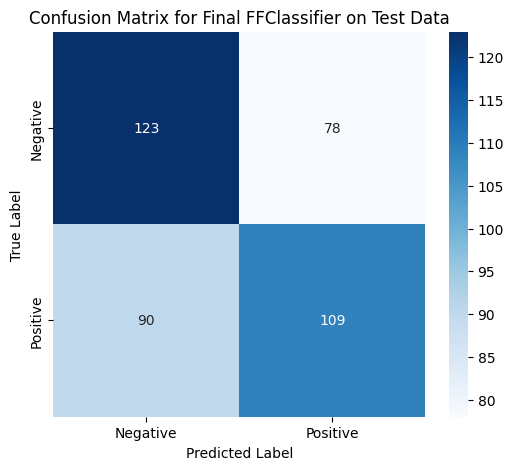

In [24]:
cm = confusion_matrix(y_test, y_test_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Final FFClassifier on Test Data')
plt.show()

## Error analysis: inspecting misclassified reviews

We now examine some **false positives** and **false negatives** to understand:

- Which linguistic phenomena confuse the model.
- How the representation (BiLSTM embeddings) might fail.
- How data sparsity, sarcasm, negation, etc. show up in errors.

I am giving you this cell.


In [33]:
# Identify misclassified indices

y_test_pred_final = y_test_pred_final.ravel()
misclassified_indices = np.where(y_test != y_test_pred_final.ravel())[0]
print('Misclassified indices:\n', misclassified_indices)

print("\nNumber of misclassified examples:", len(misclassified_indices))

# Helper function to print a few examples
def show_misclassified_examples(X_text, y_true, y_pred, indices, n=5, truncated_text=True):
    selected = np.random.choice(indices, size=min(n, len(indices)), replace=False)
    for idx in selected:
        print("="*80)
        print(f"Index: {idx}")
        print(f"True label: {y_true[idx]} ({'pos' if y_true[idx]==1 else 'neg'})")
        print(f"Predicted label: {y_pred[idx]} ({'pos' if y_pred[idx]==1 else 'neg'})")

        if truncated_text:
            print("\nReview text (truncated to 800 chars):\n")
            print(X_text[idx][:800])
        else:
            print("\nReview full text:\n")
            print(X_text[idx])
        print("\n")

truncated_text = True  # Truncate reviews to first 800 characters
num_reviews    = 10     # Display this many reviews
show_misclassified_examples(X_test, y_test, y_test_pred_final, misclassified_indices,
                            n=num_reviews, truncated_text=truncated_text)


Misclassified indices:
 [  0   4   7  10  11  12  13  22  23  24  28  29  30  32  34  35  36  39
  41  46  48  49  50  52  53  54  56  61  63  68  69  70  75  76  77  79
  82  84  85  86  87  89  94  95 105 108 109 110 111 112 114 115 120 121
 122 123 128 129 130 132 134 135 136 137 138 140 145 146 152 161 164 165
 167 168 169 170 172 174 175 178 183 185 191 193 194 196 203 206 215 216
 217 218 219 222 223 224 228 233 236 238 242 243 245 250 252 255 256 260
 262 263 266 267 271 272 275 276 278 279 280 282 283 284 287 294 296 297
 298 299 304 311 317 321 322 324 325 327 334 335 336 341 343 345 346 347
 349 350 351 352 357 359 361 365 366 368 370 375 377 379 380 381 382 383
 387 388 392 393 396 399]

Number of misclassified examples: 168
Index: 311
True label: 0 (neg)
Predicted label: 1 (pos)

Review text (truncated to 800 chars):

synopsis : a humorless police officer ' s life changes when he befriends a super - smart , super - adorable golden retriever named einstein and a cute , young

### 10. Use UMAP (imported at the beginning) to reduce the dimensionality of the test embeddings and plot them in 2 dimensions.

Individual instructions for each code cell below:
1. Print shape of test embeddings and accuracy score of the test data from Step 8 above.
2. Define UMAP model to reduce X_test_emb (if that was your variable for the test embeddings) to 2 dimensions. Use 'cosine' as the metric, your own values  for n_neighbors, min_dist, and random_state. Call fit_transform method on the X test embeddings, and save result in a variable.  Print the new shape, which should be (400, 2).
3. Create scatterplot of the ground truth labels (i.e. y_test) in the 2 dimensions with labeled axes, title, and legend. Color the plotted points by negative or positive sentiment.
4. Create similar scatterplot to display plotted points that are either correct or incorrect predictions (You can use `y_test == y_test_pred` to get those)


In [27]:
# Print shape of test embeddings and accuracy score from Step 8

print("Shape of test embeddings (X_test_emb):", X_test_emb.shape)
print("Final FFClassifier Test Accuracy (from Step 8):", accuracy_score(y_test, y_test_pred_final))

Shape of test embeddings (X_test_emb): (400, 48)
Final FFClassifier Test Accuracy (from Step 8): 0.58


In [28]:
# Run UMAP to reduce embeddings to 2D

# Define UMAP model
reducer = umap.UMAP(
    n_neighbors=15, # Example value, you can tune this
    min_dist=0.1,   # Example value, you can tune this
    metric='cosine',
    random_state=SEED
)

# Fit and transform the test embeddings
X_test_emb_2d = reducer.fit_transform(X_test_emb)

print("New shape of 2D test embeddings:", X_test_emb_2d.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


New shape of 2D test embeddings: (400, 2)


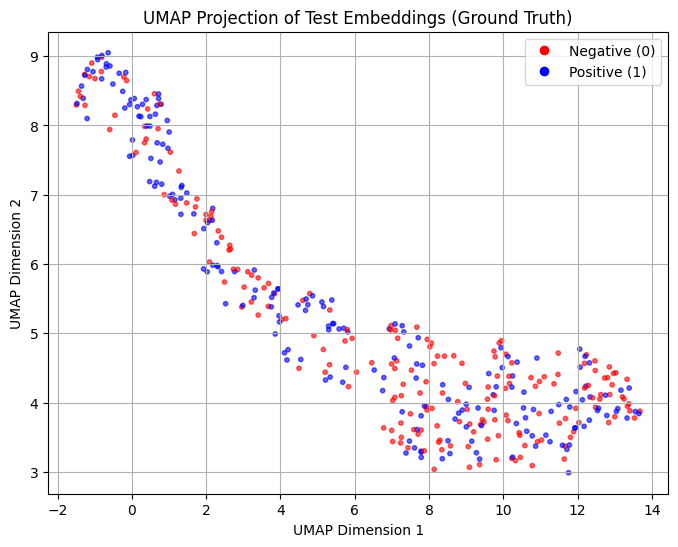

In [29]:
# Scatterplot of ground-truth sentiment clusters

plt.figure(figsize=(8, 6))
# Use y_test from the original test set for ground truth labels
colors = ['red' if label == 0 else 'blue' for label in y_test]

plt.scatter(X_test_emb_2d[:, 0], X_test_emb_2d[:, 1], c=colors, s=10, alpha=0.6)
plt.title('UMAP Projection of Test Embeddings (Ground Truth)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Create a custom legend
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Negative (0)',
                          markerfacecolor='red', markersize=8)
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Positive (1)',
                           markerfacecolor='blue', markersize=8)
plt.legend(handles=[red_patch, blue_patch])

plt.grid(True)
plt.show()

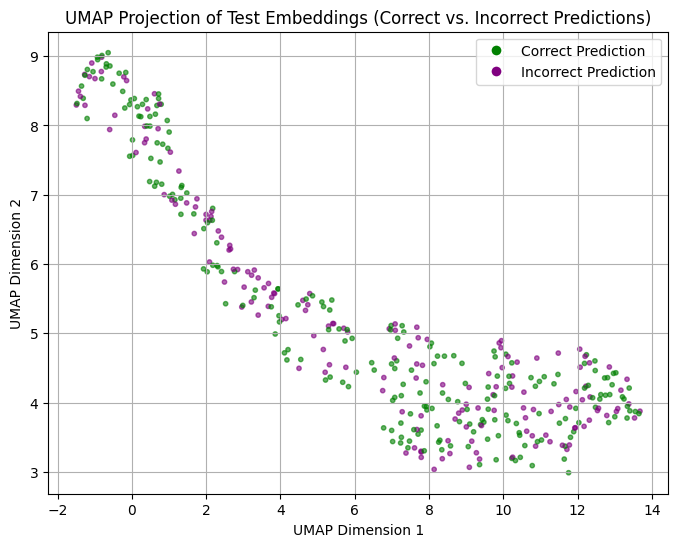

In [34]:
# Compare with scatterplot of correct vs incorrect predictions

#correct = (y_test == y_test_pred)
correct = (y_test.ravel() == y_test_pred_final.ravel())

plt.figure(figsize=(8, 6))
# Color points based on whether the prediction was correct or incorrect
colors = ['green' if c else 'purple' for c in correct]

plt.scatter(X_test_emb_2d[:, 0], X_test_emb_2d[:, 1], c=colors, s=10, alpha=0.6)
plt.title('UMAP Projection of Test Embeddings (Correct vs. Incorrect Predictions)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Create a custom legend
green_patch = plt.Line2D([0], [0], marker='o', color='w', label='Correct Prediction',
                           markerfacecolor='green', markersize=8)
purple_patch = plt.Line2D([0], [0], marker='o', color='w', label='Incorrect Prediction',
                            markerfacecolor='purple', markersize=8)
plt.legend(handles=[green_patch, purple_patch])

plt.grid(True)
plt.show()



Notice how the correct/incorrect predictions are  as thoroughtly mixed over the embedding space as the ground truth.

This is because:

- Only 2000 reviews total
- Reviews are long, messy, and full of mixed sentiment
- Many reviews contain both praise and criticism
- The writing style varies wildly (sarcasm, rhetorical questions, plot summary)
- Labels are sometimes ambiguous or borderline

#### Some topics for further thought.

1. **Reducing overfitting:**
   - Yaser Abu-Mostafa of CalTech says that learning how to deal with overfitting is what separates amateurs from professionals.
   - If your model above seems to be overfitting, what do you think are the causes and how would you procees to reduce overfitting?

2. **Embeddings as features:**
   - In Assignment 1, you used N‑gram counts or TF–IDF as features.
   - Here, you used **neural sentence embeddings**.
   - In what sense are these embeddings "just another kind of feature"?  
     In what sense are they fundamentally different?

3. **Error patterns:**
   - Look at some false positives and false negatives.
   - What linguistic patterns seem especially hard for the model?
   - How might you extend the model to handle these cases better (without jumping to Transformers yet)?

4. **Bias–variance and data limitations:**
   - How might model capacity (e.g., size of the BiLSTM or FFClassifier) affect underfitting vs overfitting here?
   - If you had access to more data, what changes would you expect in performance and error patterns?


***SUMMARY:***


---



---



**Setup and Data Loading:**

Necessary libraries like TensorFlow, Keras, NLTK, sklearn, matplotlib, seaborn, and UMAP were imported.
Random seeds were set for reproducibility.
The NLTK movie_reviews dataset was loaded, processed to extract raw text documents and sentiment labels (0 for negative, 1 for positive).

**Data Splitting:**

The dataset was split into training (64%), validation (16%), and test (20%) sets using train_test_split from scikit-learn.

**Tokenization and Padding:**

A Keras Tokenizer was fit on the training data to create a vocabulary of the MAX_VOCAB_SIZE (10,000) most frequent words.
Text reviews were converted into sequences of integer IDs and then padded or truncated to a uniform MAX_SEQ_LEN (256).

**BiLSTM Sentence Encoder Construction:**

A Keras model (biLSTM) was built, consisting of:
An Input layer.
An Embedding layer to learn word embeddings (EMBEDDING_DIM = 128).
A Bidirectional LSTM layer with 64 units per direction, configured to output a single vector (return_sequences=False).
A Dense layer with 48 units and tanh activation, named "sentence_embedding", acting as a bottleneck to produce fixed-dimensional sentence embeddings.

**BiLSTM Encoder Training (with Classification Head):**

A simple classification head (Dropout and a 1-unit Dense layer with sigmoid activation) was added temporarily to the biLSTM model for supervised training.
The biLSTM model was compiled with binary_crossentropy loss, Adam optimizer, and accuracy metrics.
The model was trained using X_train_seq and y_train, with X_val_seq and y_val for validation. EarlyStopping was used to monitor val_loss and restore the best weights.
Baseline BiLSTM Evaluation:

The biLSTM model's performance was evaluated on the X_test_seq data, and the test accuracy and a classification report were printed.

**Sentence Embedding Extraction:**

A new model (encoder_only_model) was created by extracting only the encoder part (up to the sentence_embedding layer) from the trained biLSTM.
This encoder_only_model was used to generate 48-dimensional sentence embeddings for the X_train_seq, X_val_seq, and X_test_seq datasets, storing them as X_train_emb, X_val_emb, and X_test_emb respectively.

**Feed-Forward Classifier (FFClassifier) Training:**

A new Sequential Keras model (ff_classifier) was defined with an input layer for the 48-dimensional embeddings, a Dense hidden layer with relu activation, and a Dense output layer with sigmoid activation.
This ff_classifier was compiled and trained on X_train_emb and y_train, with X_val_emb and y_val for validation, also using EarlyStopping.
The ff_classifier's performance on the validation set was then reported.

**Final Training and Evaluation:**

The training and validation embeddings (X_train_emb, X_val_emb) were combined (X_combined_train_val).
A new 90/10 train/validation split was performed on this combined data.
A final FFClassifier (ff_classifier_final) was redefined, compiled, and trained on these new train/validation sets.
This final model's performance was evaluated on the held-out X_test_emb data, and its test accuracy and classification report were printed.

**Confusion Matrix Plot:**

A confusion matrix for the ff_classifier_final on the test data was generated and plotted using seaborn.heatmap.

**UMAP Dimensionality Reduction and Visualization:**

The shape of X_test_emb and the final test accuracy were printed.
UMAP was applied to X_test_emb to reduce the embeddings to 2 dimensions (X_test_emb_2d).
Two scatterplots were generated to visualize X_test_emb_2d:
One showing the ground truth sentiment labels (negative/positive).
Another showing whether predictions were correct or incorrect.

Essentially, we've built and trained a BiLSTM encoder to generate sentence embeddings, and then used a separate Feed-Forward Neural Network to classify sentiment based on these embeddings, evaluating its performance at various stages and visualizing the embedding space.

**Reduce Overfitting :**


---


Its a very common challenge in machine learning, especially with smaller datasets like the one used here. Based on the plots of training and validation loss/accuracy, it's quite clear that the model is overfitting. Here's a breakdown of the causes and potential solutions:

***Causes of Overfitting in this Model:***

1. **Small Dataset Size (2000 reviews):**
This is arguably the biggest factor. Neural networks, especially LSTMs and deeper feed-forward networks, are powerful models with many parameters. With only 2000 training examples, the model can easily memorize the training data rather than learning generalizable patterns. The high training accuracy (often reaching 100%) combined with much lower validation accuracy is a strong indicator of this.

2. **Model Complexity (BiLSTM & FFClassifier Capacity):**

* **BiLSTM:** While 64 units per direction might not seem excessive, in a bidirectional setup, it effectively doubles the capacity. The embedding layer also introduces many parameters. The combination of these can capture noise in the limited training data.
* **FFClassifier:** Even a relatively simple FFNN with 64 units can still be too complex for the relatively small number of embeddings it's trained on (1280 embeddings for training).

3. **Lack of Sufficient Regularization (or inadequate strength):**

* We applied Dropout (0.3), but it might not be strong enough given the other factors. Dropout randomly sets a fraction of neurons to zero during training, preventing co-adaptation and encouraging more robust features.

* EarlyStopping was used, which is a good technique. It stops training when validation performance degrades, effectively finding the sweet spot before overfitting becomes too severe. However, if the validation loss starts increasing quickly after just a few epochs, it still indicates the model is too powerful for the data or not regularized enough to handle the initial learning phase without memorizing.

**How to Reduce Overfitting:**

1. **More Data:** The most effective solution, if feasible. More diverse training data would force the model to learn more general features rather than memorizing specifics. (Not an option in this assignment, but important for real-world scenarios).

2. **Increase Regularization:**
  * **Increase Dropout Rate:** Experiment with higher Dropout rates (e.g., 0.4, 0.5) in both the BiLSTM's classification head and the FFClassifier. This forces the network to learn more distributed representations.
  * **L1/L2 Regularization:** Add L1 or L2 regularization (weight decay) to the Dense layers (and possibly the LSTM cells, though that's less common). This penalizes large weights, preventing the model from becoming too complex.
  * **Batch Normalization:**
  While not strictly a regularization technique, it helps stabilize and speed up training, which can sometimes indirectly reduce overfitting by allowing for larger learning rates or more effective use of other regularization methods.

3. **Reduce Model Capacity:**

  * **Fewer LSTM Units:** Reduce the number of units in the LSTM layer (e.g., from 64 to 32 or even 16). This makes the BiLSTM less powerful and less prone to memorizing.
  * **Smaller EMBEDDING_DIM:** A smaller embedding dimension (e.g., 64 instead of 128) means words are represented by less complex vectors, reducing the total number of parameters.
  * **Fewer FFClassifier Units:** Reduce the number of units in the hidden Dense layer of the FFClassifier (e.g., from 64 to 32 or 16). You could even try a single Dense output layer directly after the sentence embeddings if the hidden layer is adding too much capacity.
  * **Simpler Architecture:** Consider if a BiLSTM is truly necessary or if a simpler architecture could suffice for such a small dataset.

4. **Early Stopping Tuning:**
While we used patience=5, it might be worth experimenting with different patience values or even different monitor metrics if val_loss isn't stable enough (e.g., val_accuracy).

5. **Data Augmentation:** For text, this is tricky but possible (e.g., synonym replacement, back-translation, random deletion/insertion of words). This artificially increases the dataset size and variety. (Likely beyond the scope of this assignment).

Given the constraints of this assignment, the most practical steps would be to experiment with increasing the dropout rate, reducing the number of LSTM units, and reducing the number of units in the FFClassifier's hidden layer. These adjustments directly target the model's capacity and its ability to memorize the training data.

**Embeddings as features:**


---



Let's break down how neural sentence embeddings compare to traditional features like N-gram counts or TF-IDF:

**In what sense are embeddings "just another kind of feature"?**
In a broad sense, both traditional methods (N-gram, TF-IDF) and neural sentence embeddings serve the same fundamental purpose: they are numerical representations of text that machine learning models can understand and use as input to make predictions or perform tasks.

  * **Input to Models:** Regardless of their origin, these numerical vectors are fed into a downstream model (like a simple classifier, a regression model, or even another neural network layer) to learn patterns and make decisions. They are the raw data, transformed into a format suitable for computation.
  * **Dimensionality Reduction/Representation:** Both aim to transform potentially complex, high-dimensional raw text data into a more manageable, numerical, fixed-dimensional representation that captures relevant information for a given task.
  * **Learned/Engineered:** Both require some form of "learning" or "engineering" to create. Traditional features are engineered based on linguistic heuristics and statistical properties (e.g., word frequencies), while embeddings are learned through a training process.

**In what sense are they fundamentally different?**
The differences are profound and highlight the power of modern deep learning approaches:

  1. **Representation Type (Sparse vs. Dense):**

  * **N-gram/TF-IDF:** Typically result in sparse, high-dimensional vectors. Most entries in these vectors are zero, as a document only contains a small fraction of all possible words/n-grams in a vocabulary. They are explicit counts or weighted counts of tokens.
  * **Neural Embeddings:** Are dense, lower-dimensional vectors. Every dimension usually holds a non-zero value, and they are not directly interpretable as counts. They represent abstract semantic and syntactic properties.
  2. **Semantic Meaning & Context:**

  * **N-gram/TF-IDF:** Capture surface-level statistical co-occurrence. They understand words primarily through their frequency and co-occurrence with other words, without inherent understanding of meaning or context beyond immediate neighbors (for N-grams). "Good" and "bad" are just different tokens; their opposition isn't explicitly encoded.
  * **Neural Embeddings:** Capture distributed, contextual semantic meaning. Words with similar meanings or that appear in similar contexts will have similar embedding vectors (e.g., "king" and "queen" might be close, and the vector difference between "king" and "man" might be similar to "queen" and "woman"). Sentence embeddings, like the BiLSTM ones you created, encode the overall meaning of an entire sentence, considering word order and interactions.
3. **Generalization & Transferability:**

  * **N-gram/TF-IDF:** Are highly specific to the vocabulary of the dataset they were generated from. They struggle with out-of-vocabulary (OOV) words and don't easily generalize to new domains without retraining.
  * **Neural Embeddings:** Can generalize better. Word embeddings often come pre-trained on massive corpora (e.g., Word2Vec, GloVe), allowing them to capture universal linguistic patterns. Sentence embeddings, even if trained on a specific task, encode more abstract representations that can sometimes be more transferable to related tasks.
4. **Learning Mechanism:**

  * **N-gram/TF-IDF:** Are hand-engineered features based on predefined algorithms (count occurrences, apply inverse document frequency weights). They don't "learn" from the task's labels.
  * **Neural Embeddings:** Are learned features through an optimization process (backpropagation). The word embeddings and the way they are combined into sentence embeddings are tuned to minimize the loss of a specific task (like sentiment classification in your case). This allows them to be highly tailored to the objective.
5. **Information Encoding:**

  * **N-gram/TF-IDF:** Primarily encode lexical information (what words are present, how often, and in what short sequences).
  * **Neural Embeddings:** Can encode much richer information, including semantic, syntactic, and even some pragmatic information about the text, based on the architecture and training data.

In essence, while both serve as numerical inputs, neural embeddings represent a shift from explicitly counting features to learning abstract, dense representations that capture much deeper linguistic properties, often leading to better performance and generalization in many NLP tasks.

**Error Patterns:**


---



Analyzing the false positives and false negatives from the misclassified examples (like the ones shown previously, e.g., index 311, 61, 304, 236), we can infer several linguistic patterns that seem especially hard for this BiLSTM model:

**Hard Linguistic Patterns for the Model:**
  1. **Sarcasm and Irony:** Phrases like "deliciously bad motion picture" (Index 304, actual negative predicted positive) are particularly challenging. The model likely identifies 'deliciously' and 'good' (implied) as positive indicators, failing to grasp the ironic inversion of meaning.

  2. **Mixed Sentiment Reviews:** Many reviews contain both positive and negative statements. For instance, a review might praise an actor's performance but criticize the plot. The model struggles to aggregate these conflicting signals into a single overall sentiment. Example 304 starts with negative quotes but then includes some positive-sounding phrases for certain audiences, which might sway the prediction.

  3. **Subtle Negation and Modifiers:** While LSTMs are better than simpler models at handling negation, complex or indirect negations can still be tricky. For example, a phrase like "not entirely without its merits" is positive, but "not worth watching" is negative. The model might miss the scope of negation or subtle intensifiers/deintensifiers. In example 311, "humorless police officer" or "rogaine-nightmare" might have been less impactful than surrounding positive words like "super-smart" or "cute" for the model.

  4. **Long-Range Dependencies and Contextual Weighting:** Although BiLSTMs are designed to capture long-range dependencies, in very long and complex reviews, the critical sentiment-determining phrases might be far from each other, or embedded within a lot of neutral text. The model might struggle to correctly weigh the importance of different segments of the review.

  5. **Subjectivity vs. Objectivity/Plot Summary:** Sometimes reviews heavily describe plot points or objective facts without expressing clear sentiment. If such a review contains some common positive or negative terms, the model might incorrectly assign sentiment where none is intended or misinterpret the main intent.


**How to Extend the Model to Handle These Cases Better (without Transformers yet):**

  1. **Use Pre-trained Word Embeddings:** Instead of learning embeddings from scratch on a relatively small dataset (even though EMBEDDING_DIM=128 helps), incorporating pre-trained word embeddings (like GloVe, Word2Vec, or FastText) would provide a richer, more general semantic understanding. These embeddings are trained on vast corpora and capture nuanced word relationships, which could help with sarcasm, idioms, and subtle sentiment.

  2. **Deeper BiLSTM or Stacked LSTMs:** Increasing the depth of the recurrent network by stacking more BiLSTM layers could allow the model to learn more abstract and hierarchical representations of the text, potentially capturing more complex contextual patterns. Be careful not to increase capacity too much, though, given the dataset size.

  3. **Attention Mechanism (Non-Transformer):** Adding an attention layer before the final sentence embedding. A simple attention mechanism would allow the model to dynamically weight different words or phrases in the input sequence when forming the final sentence representation. This could help the model focus on the most sentiment-bearing parts of a review, rather than being swayed by less relevant words, especially in mixed-sentiment cases.

  4. **Enrich Input Features:**

  * **Lexicon-based Features:** Integrate sentiment scores from external sentiment lexicons. These scores could be concatenated to word embeddings or used as additional input features, providing a direct signal about the sentiment polarity of individual words.
  * **Part-of-Speech (POS) Tagging:** Concatenating POS tags (e.g., indicating if a word is an adjective or adverb) to word embeddings could provide additional syntactic information that aids the model in disambiguating meaning, especially around negation.
5. **Refined Negation Handling:** Explicitly preprocess text to mark negated terms (e.g., converting "not good" to "not_good") or using more advanced syntactic parsers to identify the scope of negation, which can be fed as a separate feature.

6. **Ensemble Methods:** Training multiple BiLSTM models with different architectures or initializations and then averaging or voting on their predictions can often improve overall robustness and reduce the impact of individual model weaknesses.


**Bias–variance and data limitations:**


---



**How might model capacity affect underfitting vs. overfitting here?**
Model capacity refers to the complexity of the functions a model can learn. In your case, this is influenced by factors like:

  * **Number of units in the BiLSTM layers:** More units mean more parameters, increasing capacity.
  * **Dimensionality of embeddings (EMBEDDING_DIM, sentence_embedding size):** Higher dimensions allow for richer representations, also increasing capacity.
  * **Number of layers and units in the FFClassifier:** A deeper or wider FFClassifier has higher capacity.

Here's how it affects underfitting vs. overfitting:

  * **Overfitting (High Variance):** This is the more prominent issue with the current model, as indicated by the training/validation plots. With a relatively high model capacity and a small dataset, the model can easily memorize the training examples, including noise and specific quirks of the training data, rather than learning generalizable patterns. This leads to excellent performance on the training set (high training accuracy, low training loss) but poor performance on unseen data (low validation/test accuracy, increasing validation loss). The BiLSTM and FFClassifier, being neural networks, are inherently high-capacity models, making them prone to overfitting if not properly regularized or trained on sufficient data.

  * **Underfitting (High Bias):** If the model capacity were too low (e.g., a very simple BiLSTM with few units, or a shallow FFClassifier with too few neurons), the model would not be able to capture the underlying patterns and complexities in the data, even if trained extensively. This would result in poor performance on both the training and validation/test sets (low training accuracy, high training loss). In the current setup, underfitting is less likely given the architecture, but it's a possibility if we were to drastically reduce the model's complexity.

In summary, for the current scenario with a small dataset, a model with 'just right' capacity is hard to achieve; increasing capacity too much leads to overfitting, while reducing it too much could lead to underfitting. The goal is to find the sweet spot where the model is complex enough to capture patterns but simple enough not to memorize noise.

**If you had access to more data, what changes would you expect in performance and error patterns?**

Access to significantly more data would fundamentally change the training dynamics and likely lead to substantial improvements:

1. **Reduced Overfitting and Improved Generalization:**

  * With more data, the model would be exposed to a wider variety of linguistic patterns and nuances. This would make it much harder for the model to simply memorize training examples and force it to learn more robust, generalizable features.
  * We would expect the gap between training and validation/test performance to shrink significantly. The validation loss would likely decrease further and stay low for more epochs, leading to a higher final test accuracy.
  Early stopping would kick in later, or at a point where the model has learned more meaningful representations.

2. **Higher Overall Performance:**

  * The model's overall accuracy (and other metrics like precision, recall, F1-score) on the test set would almost certainly increase, as it would have learned from a more representative sample of the true data distribution.

3. **Richer Embeddings:**

  * The learned word and sentence embeddings would be much richer and more semantically meaningful. With more data, the embedding layer could learn more nuanced relationships between words, and the BiLSTM could capture more sophisticated contextual information within sentences.

4. **Changes in Error Patterns:**

  * The current error patterns (sarcasm, mixed sentiment, subtle negation) are often due to the model's inability to capture complex semantic context with limited data.
  * With more data, the model would likely make fewer errors on such challenging cases. It might start to differentiate genuine sentiment from sarcasm more effectively, or better weigh conflicting sentiments within a review.
  New, more subtle error patterns might emerge, or the existing ones would become less frequent. The model would still have limitations (e.g., extreme levels of human-like reasoning are beyond it), but its understanding of linguistic nuances would improve.

In essence, more data would allow the inherently high capacity of neural networks to be fully utilized for learning rather than memorizing, leading to a more robust, accurate, and generalizable sentiment classifier.